In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np

In [4]:
tf.__version__

'2.18.0'

In [5]:
# Data ảnh quần áo trắng đen cỡ 28 * 28 pixel, có 10 loại nhãn
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() # Tập data đã được chia sẵn làm tập train và test

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
x_train.shape # 60k ảnh cỡ 28 x 28 pixel

(60000, 28, 28)

In [7]:
set(y_train) # nhãn từ 0 -> 9

{np.uint8(0),
 np.uint8(1),
 np.uint8(2),
 np.uint8(3),
 np.uint8(4),
 np.uint8(5),
 np.uint8(6),
 np.uint8(7),
 np.uint8(8),
 np.uint8(9)}

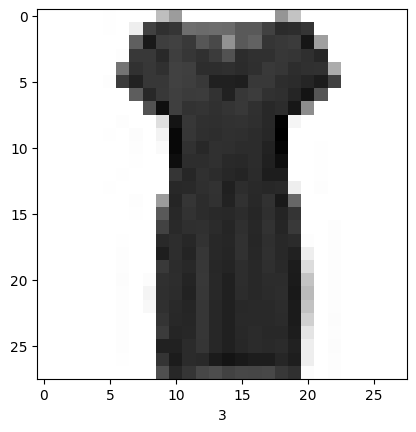

In [11]:
plt.imshow(x_train[20], cmap = 'binary')
plt.xlabel(y_train[20])
plt.show()

In [35]:
def create_model(hp): # hp(object) là một đối tượng cho phép bạn định nghĩa và chọn giá trị siêu tham số cần thử nghiệm

  # Các hyperparameters cần tinh chỉnh
  num_hidden_layers = 1 # Không chắc có bao nhiêu lớp ẩn
  num_units = 8
  dropout_rate = 0.1
  lr = 0.01

  if hp: # tức khác rỗng
    num_hidden_layers = hp.Choice('num_hidden_layers', values = [1,2,3]) # số lớp có thể là 1 hoặc 2 hoặc 3
    num_units = hp.Choice('num_units', values = [8,16,32]) # Số node trog lớp ẩn là 8/16/32
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value = 0.5)
    lr = hp.Float('lr', min_value = 0.0001, max_value = 0.01)

  model = tf.keras.models.Sequential()
  # Sequential() tạo một mô hình từng lớp một, theo thứ tự, nghĩa là mỗi lớp (layer) nối tiếp lớp trước, không có nhánh rẽ hay cấu trúc phức tạp.
  model.add(tf.keras.layers.Flatten(input_shape=(28,28))) # Trải phẳng ảnh 28 * 28 thành 784 * 1
  model.add(tf.keras.layers.Lambda(lambda x: x/255)) # Tiền xử lý - chuẩn hóa


  for _ in range (0, num_hidden_layers): # Thêm các node vào các lớp ẩn
    model.add(tf.keras.layers.Dense(num_units, activation= 'relu')) # Dense: Fully connected; Lớp ẩn đó có 8 node
    model.add(tf.keras.layers.Dropout(dropout_rate))
    '''
    Dropout sẽ ngẫu nhiên bỏ qua (drop) một tỉ lệ % số neuron trong layer hiện tại trong mỗi lần huấn luyện, nghĩa là:
      + Các neuron bị "tắt" tạm thời (không hoạt động, không tham gia truyền và cập nhật).
      + Ở mỗi epoch hoặc mỗi mini-batch, các neuron bị "drop" khác nhau.
    => kỹ thuật regularization (chống overfitting) trong mạng nơ-ron,
    '''
  model.add(tf.keras.layers.Dense(10, activation= 'softmax'))
  model.compile(
      loss='sparse_categorical_crossentropy' , # hàm mất mát (loss function) cho Bài toán phân loại đa lớp (multi-class classification),
      # nhãn là int, ko phải one-hot vector kiểu [0,0,1]
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
      metrics = ['accuracy']
  )
  return model

In [36]:
create_model(None).summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370 (24.88 KB)

 Trainable params: 6,370 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

Lớp Dense (8 node): 784 feature sau flatten × 8 + 8 bias = 6,280 tham số

(Số feature input × Số node + Số node (bias)

Lớp Dense_1 (10 node): (8 node lớp dense × 10) + 10 bias = 90



In [43]:
class CustomTuner(keras_tuner.tuners.BayesianOptimization):
  # Tùy chỉnh batch_size trong Bayes Opt của keras:
  # Tạo một lớp CustomTuner kế thừa từ keras_tuner.tuners.BayesianOptimization, cho phép Keras Tuner tự động tìm giá trị tốt nhất cho batch_size trong khoảng từ 32 đến 128
    def run_trial(self, trial, *args, **kwargs):
       kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32,128,step=32)
       #super(CustomTuner,self).run_trial(trial, *args, ** kwargs)
       results = super(CustomTuner,self).run_trial(trial, *args, ** kwargs)
       # Return the results
       return results


In [44]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials= 20, # Số lần thử nghiệm tối đa
    directory='logs', # # Thư mục lưu kết quả
    project_name = 'fashionMINST', # Tên dự án con trong thư mục 'logs'
    overwrite=True # Nếu có log cũ thì ghi đè (không tiếp tục từ lần chạy trước)
)

In [45]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


In [46]:
tuner.search(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 5, verbose = True,
)

Trial 20 Complete [00h 00m 42s]
val_accuracy: 0.8108999729156494

Best val_accuracy So Far: 0.8518000245094299
Total elapsed time: 00h 08m 19s


In [47]:
tuner.results_summary(1) # KẾT QUẢ TOP 1

Results summary
Results in logs/fashionMINST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.20598686311730408
lr: 0.005136624145904376
batch_size: 128
Score: 0.8518000245094299


In [48]:
model = tuner.get_best_models(num_models = 1)[0]
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,450 (99.41 KB)

 Trainable params: 25,450 (99.41 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
_ = model.fit(
    x_train,y_train,
    validation_data = (x_test, y_test),
    epochs=20,batch_size= 128,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8354 - loss: 0.4398 - val_accuracy: 0.8479 - val_loss: 0.4290
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8387 - loss: 0.4316 - val_accuracy: 0.8484 - val_loss: 0.4151
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8406 - loss: 0.4195 - val_accuracy: 0.8545 - val_loss: 0.4144
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8447 - loss: 0.4163 - val_accuracy: 0.8504 - val_loss: 0.4092
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8502 - loss: 0.3972 - val_accuracy: 0.8495 - val_loss: 0.4260
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8464 - loss: 0.4055 - val_accuracy: 0.8574 - val_loss: 0.4031
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8509 - loss: 0.3994 - val_accuracy: 0.8576 - val_loss: 0.3898
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8514 - loss: 0.3951 - val_accuracy: 0.